In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random

In [21]:
class Barber_shop:
  def __init__(self, n_customers, n_barbers, operation_list, customer_type, schedule, due_time, discount):
    self.n_customers = n_customers
    self.n_barbers = n_barbers
    self.operation_list = operation_list
    self.customer_type = customer_type
    self.schedule = schedule
    self.due_time = due_time
    self.operation_costs = [100, 50, 150, 200]
    self.weight = []
    self.time_required = []
    self.avg_time_req = []
    self.price = []
    self.membership = 200
    self.discount = discount

  def get_weight(self):
    for ctype in self.customer_type:
      if ctype == 'Standard':
        self.weight.append(1)
      else:
        self.weight.append(2)

  def get_operation_price(self):
    for operation in self.operation_list:
      price_j = np.dot(operation, self.operation_costs)
      self.price.append(price_j)

  def get_operation_time(self):
    for operation in self.operation_list:
      operation_times = [round(random.normalvariate(10,2)), round(random.normalvariate(5,1)), 
                        round(random.normalvariate(15,3)), round(random.normalvariate(20,5))]
      avg_op_times = [10,5,15,20]
      time_j = np.dot(operation, operation_times)
      self.time_required.append(time_j)
      time_j = np.dot(operation, avg_op_times)
      self.avg_time_req.append(time_j)

  def initialize(self):
    self.get_weight()
    self.get_operation_price()
    self.get_operation_time()

  def get_discount(self, j, schedule, time_required):
    start_time, avg_start_time = self.get_start_time(j, schedule, time_required)
    return self.discount if start_time > avg_start_time else 0

  def get_barber(self, j, schedule):
    for i in range(self.n_barbers):
      for k in schedule[i]:
        if k==j:
          return i

  def get_start_time(self, j, schedule, time_required):
    i = self.get_barber(j, schedule)
    s_i = schedule[i]
    start_j=0
    avg_start=0
    for k in s_i:
      if k==j:
        break
      start_j+=time_required[k]
      avg_start+=self.avg_time_req[k]

    return start_j

  def objective(self, schedule, time_required):
    net_profit = 0
    for j in range(self.n_customers):
      wj = self.weight[j]
      pj = self.get_discount(j, schedule, time_required)
      cj = self.price[j]

      net_profit += (1-wj*pj)*cj + (wj-1)*self.membership

    return net_profit

In [22]:
class Simulated_Annealing:
  def __init__(self, temp, alpha, stopping_temp, 
              stopping_iter, red_rule, beta, n_customers, n_barbers, operation_list, 
              customer_type, schedule, due_time, max_obj_var, discount):
    self.barber_model = Barber_shop(n_customers, n_barbers, operation_list, customer_type, schedule, due_time, discount)
    self.barber_model.initialize()
    self.time_required = self.barber_model.time_required
    self.n_customers = n_customers
    self.n_barbers = n_barbers
    self.operation_list = operation_list
    self.customer_type = customer_type
    self.due_time = due_time
    self.curr_schedule = schedule
    self.curr_obj = self.barber_model.objective(schedule, self.time_required)
    self.temp = temp
    self.alpha = alpha
    self.stopping_temp = stopping_temp
    self.stopping_iter = stopping_iter
    self.red_rule = red_rule
    self.beta = beta
    self.num_iterations = 0
    self.obj_list = [self.curr_obj]
    self.var_list = []
    self.max_obj_var = max_obj_var

  def temp_reduction_rule(self):
    if self.red_rule == 'linear':
      self.temp -= self.alpha

    elif self.red_rule == 'geometric':
      self.temp *= self.alpha

    else:
      self.temp = self.temp/(1+self.beta*self.temp)

  def get_obj_variance(self, schedule):
    obj_list = []
    for i in range(50):
      op_times_random = []
      for operation in self.operation_list:
        operation_times = [round(random.normalvariate(10,2)), round(random.normalvariate(5,1)), 
                          round(random.normalvariate(15,3)), round(random.normalvariate(20,5))]
        time_j = np.dot(operation, operation_times)
        op_times_random.append(time_j)

      obj_list.append(self.barber_model.objective(schedule, op_times_random))
    
    return np.var(obj_list)

  def get_neighbour(self):
    while True:
      neighbour = self.curr_schedule
      barber1 = 0
      barber2 = 0
      while(barber1 == barber2):
        barber1 = random.randint(0,self.n_barbers - 1)
        barber2 = random.randint(0,self.n_barbers - 1)

      barber1_sch = neighbour[barber1]
      barber2_sch = neighbour[barber2]

      idx1 = len(barber1_sch)
      idx2 = len(barber2_sch)

      while(idx1 == len(barber1_sch) and idx2 == len(barber2_sch)):
        idx1 = random.randint(0,len(barber1_sch))
        idx2 = random.randint(0,len(barber2_sch))

      if idx1!=len(barber1_sch) and idx2!=len(barber2_sch):
        j1 = barber1_sch[idx1]
        j2 = barber2_sch[idx2]

        neighbour[barber1][idx1] = j2
        neighbour[barber2][idx2] = j1

      elif idx1==len(barber1_sch) and idx2!=len(barber2_sch):
        j2 = barber2_sch[idx2]

        neighbour[barber1].append(j2)
        neighbour[barber2].remove(j2)

      elif idx1 != len(barber1_sch):
        j1 = barber1_sch[idx1]

        neighbour[barber2].append(j1)
        neighbour[barber1].remove(j1)

      neighbour_var = self.get_obj_variance(neighbour)
      if neighbour_var <= self.max_obj_var:
        self.var_list.append(neighbour_var)
        return neighbour
  
  def p_accept(self, neighbour):
    s = self.curr_obj
    s_dash = self.barber_model.objective(neighbour, self.time_required)
    p = math.exp((s_dash-s)/self.temp)
    return min(1, p)

  def accept(self,neighbour):
    s_dash = self.barber_model.objective(neighbour, self.time_required)
    s = self.curr_obj

    if s_dash > s:
      self.curr_schedule = neighbour
      self.curr_obj = s_dash

    else:
      p_acc = self.p_accept(neighbour)
      epsilon = 0.8
      if epsilon < p_acc:
        self.curr_schedule = neighbour
        self.curr_obj = s_dash

  def anneal(self):
    while self.temp>=self.stopping_temp:
      self.num_iterations = 0
      while self.num_iterations < self.stopping_iter:
        neighbour = self.get_neighbour()
        self.accept(neighbour)
        self.obj_list.append(self.curr_obj)
        self.num_iterations+=1
      self.temp_reduction_rule()

    return self.curr_schedule, self.obj_list, self.var_list

In [9]:
def generate_operations(n_customers, n_operations):
  operation_list = []
  for _ in range(n_customers):
    op = [random.randint(0,1) for j in range(n_operations)]
    operation_list.append(op)

  return operation_list

In [19]:
def generate_customer_type(n_customers):
  std = int(0.7*n_customers)
  type_list = ['Standard' for i in range(std)]
  prem_cust = ['Premium' for i in range(n_customers - std)]
  type_list.append(prem_cust)
  random.shuffle(type_list)
  return type_list

In [11]:
def generate_due_time(n_customers,n_barbers):
  return [
      random.randint(50, 10 * int(n_customers / n_barbers))
      for i in range(n_customers)
  ]                           

In [12]:
def generate_random_schedule(n_customers, n_barbers):
  customer_list = list(range(n_customers))
  schedule = []
  for j in range(n_barbers):
    if j == n_barbers - 1:
      schedule.append(customer_list[int(j*(n_customers/n_barbers)):n_customers])
    schedule.append(customer_list[int(j*(n_customers/n_barbers)):int((j+1)*(n_customers/n_barbers))])

  return schedule

In [15]:
temp = 500
alpha = 5
n_operations = 4
red_rule = 'linear'
beta = 100
n_customers = 80
stopping_iter = 10
n_barbers = 3
stopping_temp = 20
max_obj_var = 500
operation_list = generate_operations(n_customers, n_operations) #each element will be a one-hot encoded vector
customer_type = generate_customer_type(n_customers)
due_time = generate_due_time(n_customers,n_barbers)
schedule = generate_random_schedule(n_customers, n_barbers)
discount = 0.2

In [16]:
simulated_anneal = Simulated_Annealing(temp, alpha, stopping_temp, 
               stopping_iter, red_rule, beta, n_customers, n_barbers, operation_list, 
               customer_type, schedule, due_time, max_obj_var, discount)

opt_schedule, obj_list, var_list = simulated_anneal.anneal()

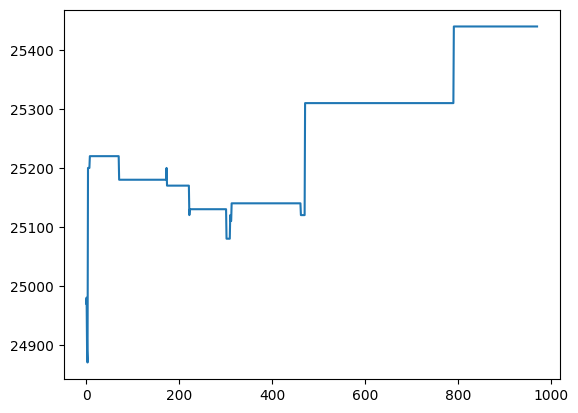

In [17]:
plt.plot(obj_list)

In [ ]:
def sigmoid(x):
    return 1/(1+math.exp(-(x)))